# Tringa's Salient Object Detection Demo✨

Welcome to my interactive demo, where you can run pieces of my SOD Project, showing how a SOD model works and predictions are visualized. This project uses an ECSSD dataset of 1200 images (from Kaggle), to train a machine learning model from scratch, and to save the best model to predict salient objects using the help of different libraries. For this demo, we are loading the dataset from Google Drive and the source code from my GitHub Repository "SOD-Project", as specified below:

**IMPORTANT:** Change Runtime Type to T4 GPU for higher performance!

> Runtime > Change runtime type > Hardware accelerator > T4 GPU





---



## 1. Import dataset and model weights from drive folder:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Clone project Git Repository:

In [2]:
!git clone https://github.com/tringadesku-genpact/SOD-Project

Cloning into 'SOD-Project'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 94 (delta 46), reused 74 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 31.47 KiB | 5.24 MiB/s, done.
Resolving deltas: 100% (46/46), done.


## 3. Change directory to source code:

In [3]:
%cd SOD-Project/

/content/SOD-Project


<small>(OPTIONAL IF REQUIREMENTS NOT AVAILABLE)</small>

In [ ]:
!pip install -r requirements.txt

<small>(OPTIONAL IF REPO NOT RECENTLY CLONED) Pull changes from Git Repository:</small>

In [ ]:
!git pull

## 4. Run Demo Code for Single Image Mask Prediction (upload image):

Using device: cuda
Loading: /content/drive/MyDrive/SOD/models/sod_improved_dropout03_full.pth
Model loaded successfully!


Saving DSC08240.JPG to DSC08240 (1).JPG
Uploaded: DSC08240 (1).JPG
Inference time: 11.54 ms


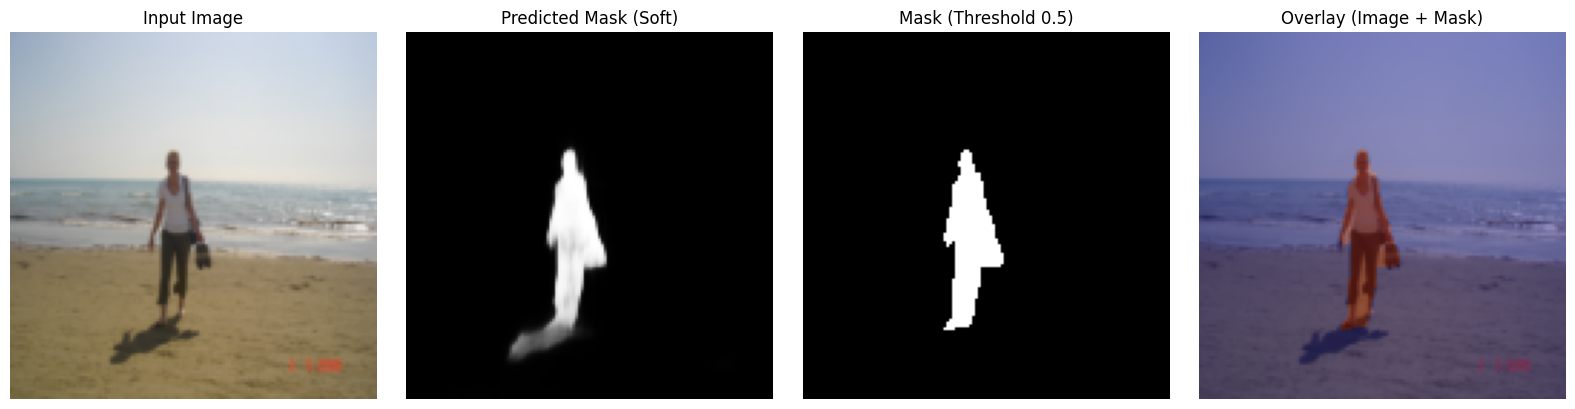


=== SUMMARY ===
• Inference time: 11.54 ms
• Displayed: input, mask, threshold, overlay


In [5]:
from google.colab import files
import torch, time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from pathlib import Path

# Load model
from config import IMAGE_SIZE, MODELS_DIR
from sod_model import SODNetImproved as SODNet   # change if needed

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model_path = MODELS_DIR / "sod_improved_dropout03_full.pth"   # change if needed
print("Loading:", model_path)

model = SODNet().to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Model loaded successfully!")

# Upload image
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded:", filename)

# Preprocess
img_pil = Image.open(filename).convert("RGB")

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

img_tensor = transform(img_pil).unsqueeze(0).to(device)   # [1, 3, H, W]

# Inference + timing
start = time.time()

with torch.no_grad():
    logits = model(img_tensor)

if device == "cuda":
    torch.cuda.synchronize()

elapsed_ms = (time.time() - start) * 1000
print(f"Inference time: {elapsed_ms:.2f} ms")

# Convert to masks
probs = torch.sigmoid(logits)      # soft mask
mask = probs[0, 0].cpu().numpy()   # [H,W]
mask_bin = (mask > 0.5).astype(np.float32)

# Convert image to numpy array
img_np = img_tensor[0].cpu().numpy().transpose(1, 2, 0)

# Visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original
axes[0].imshow(img_np)
axes[0].set_title("Input Image")
axes[0].axis("off")

# Soft mask
axes[1].imshow(mask, cmap="gray")
axes[1].set_title("Predicted Mask (Soft)")
axes[1].axis("off")

# Threshold mask
axes[2].imshow(mask_bin, cmap="gray")
axes[2].set_title("Mask (Threshold 0.5)")
axes[2].axis("off")

# Overlay
axes[3].imshow(img_np)
axes[3].imshow(mask_bin, cmap="jet", alpha=0.4)
axes[3].set_title("Overlay (Image + Mask)")
axes[3].axis("off")

plt.tight_layout()
plt.show()

print("\n=== SUMMARY ===")
print(f"• Inference time: {elapsed_ms:.2f} ms")
print("• Displayed: input, mask, threshold, overlay")




---


<small> (OPTIONAL) Run code to compare best weights/metrics from each model: </small>

In [6]:
import pandas as pd
from pathlib import Path
from config import MODELS_DIR

# List the experiments you want to compare
experiments = [
    "best_model",
    "sod_improved_dropout03_full",
    "sod_improved_v2",
]

rows = []

for exp in experiments:
    csv_path = MODELS_DIR / f"{exp}_history.csv"
    if not csv_path.is_file():
        print(f"⚠️ No history for {exp} at {csv_path}")
        continue

    df = pd.read_csv(csv_path)

    # Option A: take the row with the best (lowest) val_loss
    best_idx = df["val_loss"].astype(float).idxmin()
    best_row = df.loc[best_idx]

    rows.append({
        "Experiment": exp,
        "Best val_loss": float(best_row["val_loss"]),
        "Best val_IoU": float(best_row["val_iou"]),
        "Best train_loss": float(best_row["train_loss"]),
        "Best train_IoU": float(best_row["train_iou"]),
    })

results_df = pd.DataFrame(rows)
results_df


,Experiment,Best val_loss,Best val_IoU,Best train_loss,Best train_IoU
0,best_model,0.540120,0.592184,0.557448,0.610949
1,sod_improved_dropout03_full,0.471991,0.658577,0.441010,0.695846
2,sod_improved_v2,0.518760,0.615473,0.448325,0.680298


<small> (OPTIONAL) Run to compare visually compare all three models: </small>

Using device: cuda
✓ Baseline loaded
✓ Improved (Dropout 0.3) loaded
✓ Improved V2 (Residual + Dropout) loaded
Dataset root: /content/drive/MyDrive/SOD/dataset_ecssd
Images: 1200, Masks: 1200
Total samples: 1200
Train: 840
Val:   180
Test:  180
→ Batch loaded for comparison.



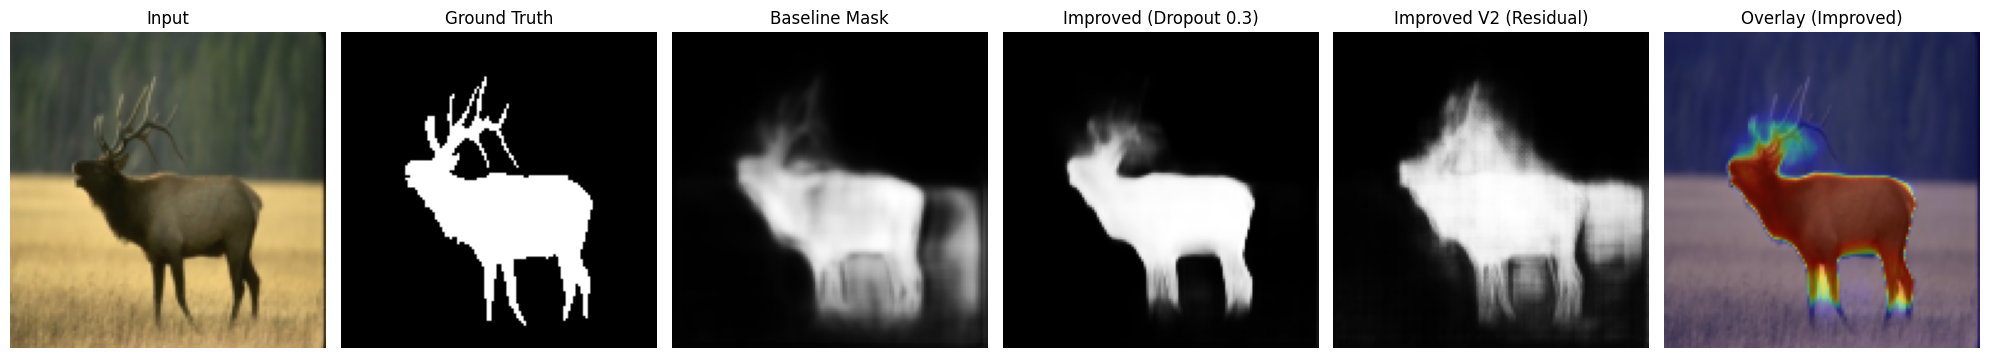

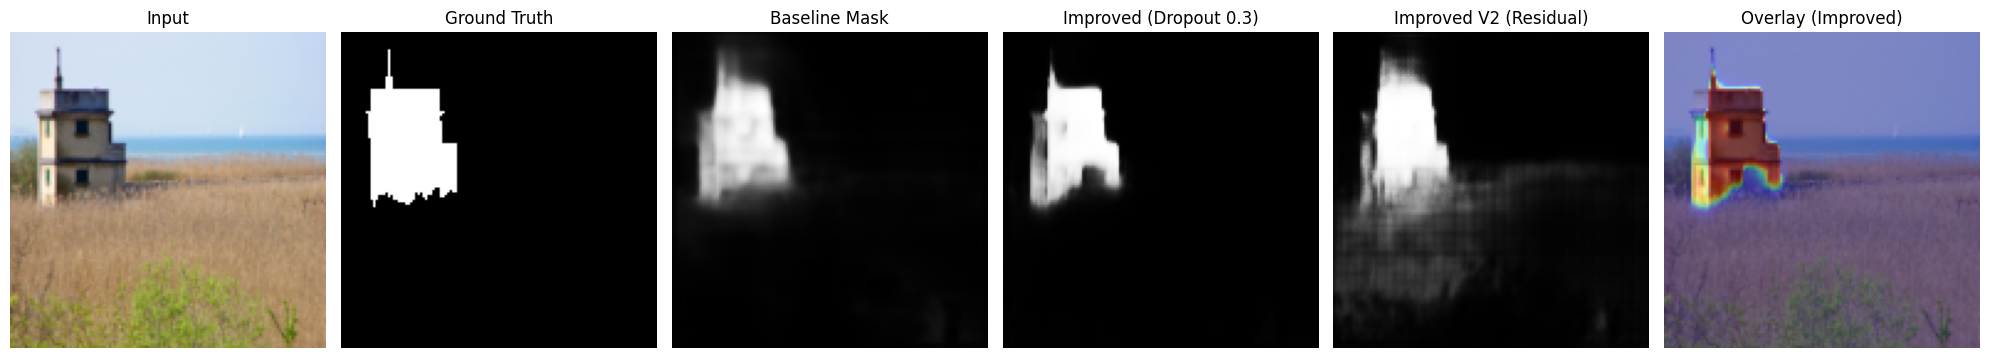

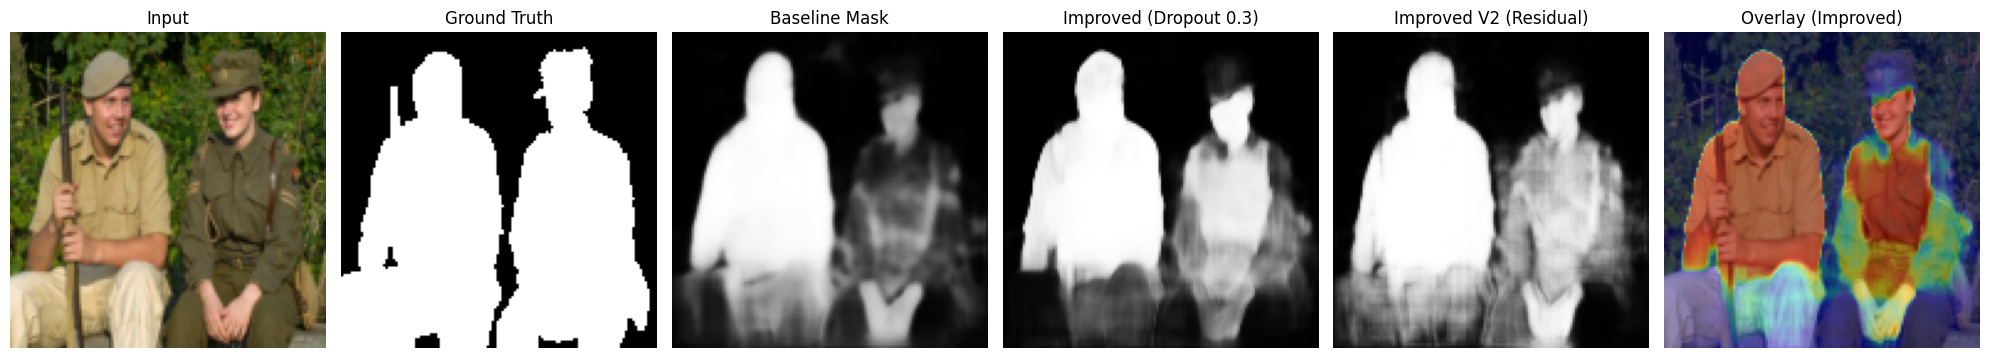

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data_loader import get_dataloaders
from sod_model import SODNetBaseline, SODNetImproved, SODNetImprovedV2
from config import BATCH_SIZE, NUM_WORKERS, MODELS_DIR

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Baseline model
baseline_path = MODELS_DIR / "best_model.pth"
baseline = SODNetBaseline().to(device)
baseline.load_state_dict(torch.load(baseline_path, map_location=device))
baseline.eval()
print("✓ Baseline loaded")

# Improved (Dropout)
improved_path = MODELS_DIR / "sod_improved_dropout03_full.pth"
improved = SODNetImproved(p_dropout=0.3).to(device)
improved.load_state_dict(torch.load(improved_path, map_location=device))
improved.eval()
print("✓ Improved (Dropout 0.3) loaded")

# Improved V2 (Residual + Dropout)
improved_v2_path = MODELS_DIR / "sod_improved_v2.pth"
improved_v2 = SODNetImprovedV2(p_dropout=0.3).to(device)
improved_v2.load_state_dict(torch.load(improved_v2_path, map_location=device))
improved_v2.eval()
print("✓ Improved V2 (Residual + Dropout) loaded")


_, _, test_loader = get_dataloaders(
    batch_size=BATCH_SIZE,
    limit=None,
    num_workers=NUM_WORKERS,
)

batch = next(iter(test_loader))
images = batch["images"].to(device)
masks  = batch["masks"].to(device)

print("→ Batch loaded for comparison.\n")

with torch.no_grad():
    logits_base = baseline(images)
    logits_impr = improved(images)
    logits_impr2 = improved_v2(images)

# Convert to probabilities
probs_base  = torch.sigmoid(logits_base).cpu().numpy()
probs_impr  = torch.sigmoid(logits_impr).cpu().numpy()
probs_impr2 = torch.sigmoid(logits_impr2).cpu().numpy()

imgs_np  = images.cpu().numpy()
masks_np = masks.cpu().numpy()

# VISUALIZATION
num_show = min(3, imgs_np.shape[0])

for i in range(num_show):
    img    = imgs_np[i].transpose(1, 2, 0)
    gt     = masks_np[i, 0]
    pred_b = probs_base[i, 0]
    pred_i = probs_impr[i, 0]
    pred_i2 = probs_impr2[i, 0]

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))

    axes[0].imshow(img)
    axes[0].set_title("Input")
    axes[0].axis("off")

    axes[1].imshow(gt, cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(pred_b, cmap="gray")
    axes[2].set_title("Baseline Mask")
    axes[2].axis("off")

    axes[3].imshow(pred_i, cmap="gray")
    axes[3].set_title("Improved (Dropout 0.3)")
    axes[3].axis("off")

    axes[4].imshow(pred_i2, cmap="gray")
    axes[4].set_title("Improved V2 (Residual)")
    axes[4].axis("off")

    axes[5].imshow(img)
    axes[5].imshow(pred_i, cmap="jet", alpha=0.4)
    axes[5].set_title("Overlay (Improved)")
    axes[5].axis("off")

    plt.tight_layout()
    plt.show()



<small>(OPTIONAL) Run to demonstrate training of model:</small>

In [8]:
!python /content/SOD-Project/train.py


Using device: cuda
Dataset root: /content/drive/MyDrive/SOD/dataset_ecssd
Images: 1200, Masks: 1200
Total samples: 1200
Train: 840
Val:   180
Test:  180
Found existing model at /content/drive/MyDrive/SOD/models/sod_improved_dropout03_full.pth. Loading weights...
→ Weights loaded, training will continue from this checkpoint.
/content/SOD-Project/train.py:129: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))

Epoch 1/25
Train:   0% 0/105 [00:00<?, ?it/s]/content/SOD-Project/train.py:157: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):
  Train loss: 0.3150 | Train IoU: 0.7714
  Val loss:   0.5209 | Val IoU: 0.6532
  → Saved new best model to /content/drive/MyDrive/SOD/models/sod_improved_dropout03_full.pth

Epoch 2/25
  Train loss: 0.3959 | Trai

<small>(OPTIONAL) Run to demonstrate evaluation of best model:</small>

In [24]:
!python  /content/SOD-Project/evaluate.py


Using device: cuda
Model path: /content/drive/MyDrive/SOD/models/sod_improved_dropout03_full.pth
Dataset root: /content/drive/MyDrive/SOD/dataset_ecssd
Images: 1200, Masks: 1200
Total samples: 1200
Train: 840
Val:   180
Test:  180
Loaded model weights.

Test results (averaged over test set):
  Test loss:       0.4621
  Test IoU:        0.64902410040731017826232118750340305268764496
  Test Precision:  0.7663
  Test Recall:     0.7995
  Test F1-score:   0.7807
  Test Mean Absolute Error:        0.1231
Saved /content/drive/MyDrive/SOD/outputs/sample_0.png
Saved /content/drive/MyDrive/SOD/outputs/sample_1.png
Saved /content/drive/MyDrive/SOD/outputs/sample_2.png
